### Dependences

In [1]:
import sys
sys.path.append("../")

import math
from tqdm import tqdm
import numpy as np
import tensorflow as tf

from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
from IPython.display import clear_output


import lib.utils as utils

import IPython.display as ipd


### Loading experiment data

In [2]:
#set experiment ID
EXP_ID = "Efficient_UNet_v2"
utils.create_experiment_folders(EXP_ID)
utils.load_experiment_data()


### Model instantiation

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, BatchNormalization, ReLU

backbone = tf.keras.applications.EfficientNetB0(include_top=False, weights=None, input_shape=(128, 128, 1))
skip_connection_layers = ('block6a_expand_activation', 'block4a_expand_activation', 'block3a_expand_activation', 'block2a_expand_activation')

skips = ([backbone.get_layer(name=i).output if isinstance(i, str) else backbone.get_layer(index=i).output for i in skip_connection_layers])
initializer = tf.keras.initializers.GlorotNormal(seed=0)

input_ = backbone.input
x = backbone.output

# building decoder blocks
up_1 = Conv2DTranspose(512, 4, strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(x)
up_1 = BatchNormalization()(up_1)
up_1 = ReLU()(up_1)
concat_1 = Concatenate(axis=3)([up_1, skips[0]])
conv_1 = Conv2D(512, 3, kernel_initializer=initializer, padding='same')(concat_1)
conv_1 = BatchNormalization()(conv_1)
conv_1 = ReLU()(conv_1)


up_2 = Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(conv_1)
up_2 = BatchNormalization()(up_2)
up_2 = ReLU()(up_2)
concat_2 = Concatenate(axis=3)([up_2, skips[1]])
conv_2 = Conv2D(256, 3, kernel_initializer=initializer, padding='same')(concat_2)
conv_2 = BatchNormalization()(conv_2)
conv_2 = ReLU()(conv_2)


up_3 = Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(conv_2)
up_3 = BatchNormalization()(up_3)
up_3 = ReLU()(up_3)
concat_3 = Concatenate(axis=3)([up_3, skips[2]])
conv_3 = Conv2D(128, 3, kernel_initializer=initializer, padding='same')(concat_3)
conv_3 = BatchNormalization()(conv_3)
conv_3 = ReLU()(conv_3)

up_4 = Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(conv_3)
up_4 = BatchNormalization()(up_4)
up_4 = ReLU()(up_4)
concat_4 = Concatenate(axis=3)([up_4, skips[3]])
conv_4 = Conv2D(64, 3, kernel_initializer=initializer, padding='same')(concat_4)
conv_4 = BatchNormalization()(conv_4)
conv_4 = ReLU()(conv_4)

up_5 = Conv2DTranspose(32, 4, strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(conv_4)
up_5 = BatchNormalization()(up_5)
up_5 = ReLU()(up_5)
conv_5 = Conv2D(32, 3, kernel_initializer=initializer, padding='same')(up_5)
conv_5 = BatchNormalization()(conv_5)
conv_5 = ReLU()(conv_5)


output = Conv2D(1, 3, strides=1, padding='same', kernel_initializer=initializer)(conv_5)


model = Model(inputs=input_, outputs=output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 128, 128, 1)  3           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 1)  0           normalization[0][0]              
_______________________________________________________________________________________

In [ ]:
# model = Res_UNet_v2()
# model.build((None,128,128,1))
# print(model.summary())

### Loading Dataset

In [4]:
train_x = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_train.npy", mmap_mode='c') 
train_y = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_train.npy", mmap_mode='c') 

qtd_traning = train_x.shape
print("Loaded",qtd_traning, "samples")


Loaded (371026, 128, 128, 1) samples


In [5]:
valid_x_1 = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_val.npy", mmap_mode='c') 
valid_y_1 = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_val.npy", mmap_mode='c')

qtd_traning = valid_x_1.shape
print("Loaded",qtd_traning, "samples")


Loaded (92800, 128, 128, 1) samples


### Dataset Normalization and Batches split

In [6]:
value = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/scale_and_shift.npy", mmap_mode='c') 
print(value)
SHIFT_VALUE_X, SHIFT_VALUE_Y, SCALE_VALUE_X, SCALE_VALUE_Y = value[0], value[1], value[2], value[3]
# SHIFT_VALUE_X, SHIFT_VALUE_Y, SCALE_VALUE_X, SCALE_VALUE_Y = utils.get_shift_scale_maxmin(train_x, train_y, valid_x_1, valid_y_1)

mini_batch_size = 58
num_train_minibatches = math.floor(train_x.shape[0]/mini_batch_size)
num_val_minibatches = math.floor(valid_x_1.shape[0]/mini_batch_size)

print("train_batches:", num_train_minibatches, "valid_batches:", num_val_minibatches)


[ -0.          -0.         127.97928619 127.98652649]
train_batches: 6397 valid_batches: 1600


### Metrics

In [7]:
#default tf.keras metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')

### Set Loss and load model weights

In [8]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#get last saved epoch index and best result in validation step
CURRENT_EPOCH, BEST_VALIDATION = utils.get_model_last_data()
if CURRENT_EPOCH > 0:
    print("Loading last model state in epoch", CURRENT_EPOCH)
    model.load_weights(utils.get_exp_folder_last_epoch())
    print("Best validation result was PSNR=", BEST_VALIDATION)

### Training

VALIDATION EPOCH 0


  0%|          | 1/1600 [00:00<04:55,  5.41it/s]

Validation set


100%|██████████| 1600/1600 [05:41<00:00,  4.69it/s]


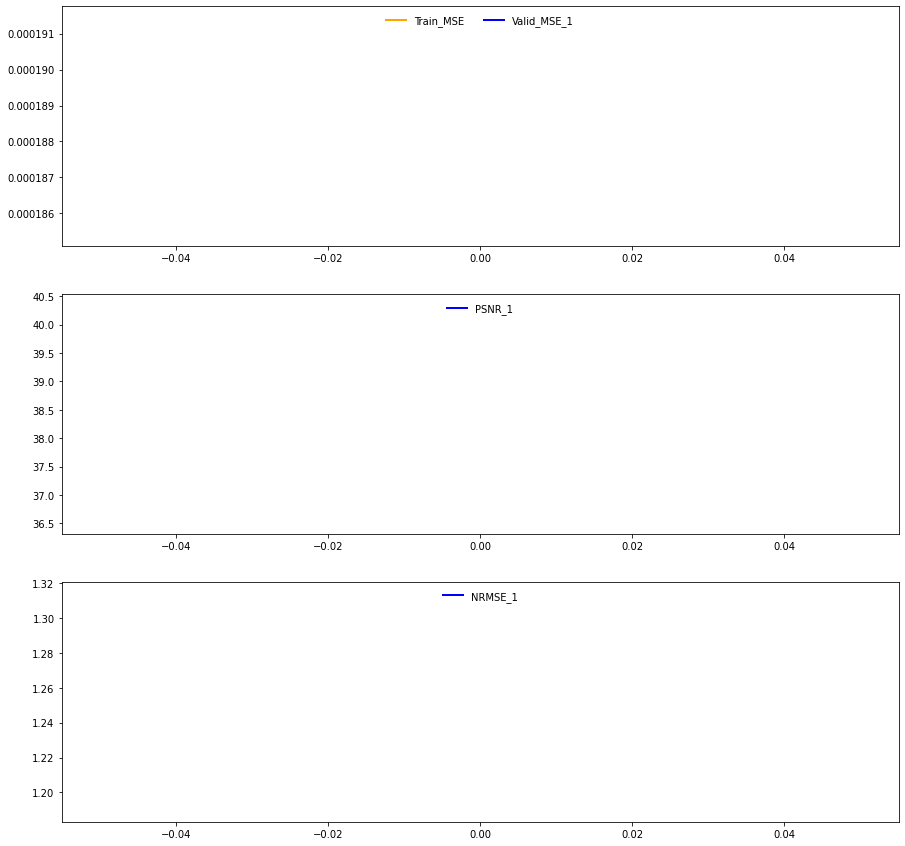

  0%|          | 0/6397 [00:00<?, ?it/s]

TRAINING EPOCH 1


 10%|▉         | 610/6397 [02:53<28:05,  3.43it/s]

In [ ]:
@tf.function
def train_step(patch_x, patch_y):
    with tf.GradientTape() as tape:
        predictions = model(patch_x)
        loss = loss_object(patch_y, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)

def valid_step(valid_x, valid_y, num_val_minibatches, mini_batch_size):
    valid_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')
    valid_custom_metrics = utils.CustomMetric()
    for i in tqdm(range(num_val_minibatches)):
        data_x = valid_x[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
        data_y = valid_y[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
        
        data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)
        data_y = tf.convert_to_tensor(data_y, dtype=tf.float32)
        
        data_x = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
        data_y = ((data_y+SHIFT_VALUE_Y)/SCALE_VALUE_Y)+CONST_GAMA
        
        predictions = model(data_x)
        valid_mse(data_y, predictions)

        predictions = predictions.numpy()
        data_y = data_y.numpy()
        
        #feed the metric evaluator
        valid_custom_metrics.feed(data_y, predictions)

    #get metric results
    psnr, nrmse = valid_custom_metrics.result()
    valid_mse_result = valid_mse.result().numpy()
    valid_custom_metrics.reset_states()
    valid_mse.reset_states()
    return psnr, nrmse, valid_mse_result
    
MAX_EPOCHS = 100
EVAL_STEP = 1
CONST_GAMA = 0.001


for epoch in range(CURRENT_EPOCH, MAX_EPOCHS):
    
    #TRAINING
    print("TRAINING EPOCH", epoch)
   
    for k in tqdm(range(0, num_train_minibatches)):
        seismic_x = train_x[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        seismic_y = train_y[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        
        seismic_x = tf.convert_to_tensor(seismic_x, dtype=tf.float32)
        seismic_y = tf.convert_to_tensor(seismic_y, dtype=tf.float32)
        
        seismic_x = ((seismic_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
        seismic_y = ((seismic_y+SHIFT_VALUE_Y)/SCALE_VALUE_Y)+CONST_GAMA
        
        train_step(seismic_x, seismic_y)
        
    #VALIDATION
    if epoch%EVAL_STEP == 0:
        clear_output()
        
        print("VALIDATION EPOCH", epoch)
        #saving last epoch model
        model.save_weights(utils.get_exp_folder_last_epoch(), save_format='tf')
       
        #valid with set 1
        print("Validation set")
        psnr_1, nrmse_1, mse_1 = valid_step(valid_x_1, valid_y_1, num_val_minibatches, mini_batch_size)
        
        #valid with set 2
        #print("Validation set 2")
        #psnr_2, nrmse_2, mse_2 = valid_step(valid_x_2, valid_y_2, num_val_minibatches, mini_batch_size)
        psnr_2, nrmse_2, mse_2 = 0, 0, 0
        
        #valid with set 3
        #print("Validation set 3")
        #psnr_3, nrmse_3, mse_3 = valid_step(valid_x_3, valid_y_3, num_val_minibatches, mini_batch_size)
        psnr_3, nrmse_3, mse_3 = 0, 0, 0
        
        utils.update_chart_data(epoch=epoch, train_mse=train_loss.result().numpy(), 
                                valid_mse=[mse_1,mse_2,mse_3], psnr=[psnr_1,psnr_2,psnr_3], nrmse=[nrmse_1,nrmse_2, nrmse_3])
        utils.draw_chart()
        
        #saving best validation model
        if psnr_1 > BEST_VALIDATION:
            BEST_VALIDATION = psnr_1
            model.save_weights(utils.get_exp_folder_best_valid(), save_format='tf')
        
    train_loss.reset_states()


In [ ]:
utils.draw_chart()

In [ ]:
#experimentos results
print(utils.get_experiment_results())

In [ ]:
#load best model
model.load_weights(utils.get_exp_folder_best_valid())
CONST_GAMA = 0.001

# valid_x_1 = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_val.npy", mmap_mode='c') 
# valid_y_1 = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_val.npy", mmap_mode='c')

qtd_traning = valid_x_1.shape
print("Loaded",qtd_traning, "samples")

# #normalization
# test_x = utils.shift_and_normalize(test_x, SHIFT_VALUE_X, SCALE_VALUE_X)
# test_y = utils.shift_and_normalize(test_y, SHIFT_VALUE_Y, SCALE_VALUE_Y) 

#batches
num_val_minibatches = math.floor(valid_x_1.shape[0]/mini_batch_size)
# test_batches = utils.random_mini_batches(test_x, test_y, None, None, 8, seed=0)

#metrics
val_mse = tf.keras.metrics.MeanSquaredError(name='val_mse')
val_custom_metrics = utils.CustomMetric()


import json
f = open('/home/arthursrr/Documentos/Audio_Inpainting/Datasets/idx_genders_val.json', "r") 
idx_gen = json.loads(f.read()) 

for k in idx_gen:
    for i in tqdm(idx_gen[k]):
        data_x = valid_x_1[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
        data_y = valid_y_1[i * mini_batch_size : i * mini_batch_size + mini_batch_size]

        data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)
        data_y = tf.convert_to_tensor(data_y, dtype=tf.float32)

        data_x = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
        data_y = ((data_y+SHIFT_VALUE_Y)/SCALE_VALUE_Y)+CONST_GAMA

        predictions = model(data_x)
        test_mse(data_y, predictions)

        predictions = predictions.numpy()
        data_y = data_y.numpy()

        #feed the metric evaluator
        val_custom_metrics.feed(data_y, predictions)

    #get metric results
    psnr, nrmse = val_custom_metrics.result()
    val_mse_result = test_mse.result().numpy()
    val_custom_metrics.reset_states()
    val_mse.reset_states()
    
    print(k ,"\nPSNR:", psnr,"\nNRMSE:", nrmse)

# Closing file 
f.close() 

## Test

In [ ]:
#load best model
model.load_weights(utils.get_exp_folder_best_valid())
CONST_GAMA = 0.001
test_x = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_test.npy", mmap_mode='c') 
test_y = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_test.npy", mmap_mode='c')

qtd_traning = test_x.shape
print("Loaded",qtd_traning, "samples")

# #normalization
# test_x = utils.shift_and_normalize(test_x, SHIFT_VALUE_X, SCALE_VALUE_X)
# test_y = utils.shift_and_normalize(test_y, SHIFT_VALUE_Y, SCALE_VALUE_Y) 

#batches
num_test_minibatches = math.floor(test_x.shape[0]/mini_batch_size)
# test_batches = utils.random_mini_batches(test_x, test_y, None, None, 8, seed=0)

#metrics
test_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')
test_custom_metrics = utils.CustomMetric()


import json
f = open('/home/arthursrr/Documentos/Audio_Inpainting/Datasets/idx_genders_test.json', "r") 
idx_gen = json.loads(f.read()) 

for k in idx_gen:
    for i in tqdm(idx_gen[k]):
        data_x = test_x[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
        data_y = test_y[i * mini_batch_size : i * mini_batch_size + mini_batch_size]

        data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)
        data_y = tf.convert_to_tensor(data_y, dtype=tf.float32)

        data_x = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
        data_y = ((data_y+SHIFT_VALUE_Y)/SCALE_VALUE_Y)+CONST_GAMA

        predictions = model(data_x)
        test_mse(data_y, predictions)

        predictions = predictions.numpy()
        data_y = data_y.numpy()

        #feed the metric evaluator
        test_custom_metrics.feed(data_y, predictions)

    #get metric results
    psnr, nrmse = test_custom_metrics.result()
    test_mse_result = test_mse.result().numpy()
    test_custom_metrics.reset_states()
    test_mse.reset_states()
    
    print(k ,"\nPSNR:", psnr,"\nNRMSE:", nrmse)

# Closing file 
f.close() 

In [ ]:
def griffin_lim(S, frame_length=256, fft_length=255, stride=64):
    '''
    TensorFlow implementation of Griffin-Lim
    Based on https://github.com/Kyubyong/tensorflow-exercises/blob/master/Audio_Processing.ipynb
    '''
    S = tf.expand_dims(S, 0)
    S_complex = tf.identity(tf.cast(S, dtype=tf.complex64))
    y = tf.signal.inverse_stft(S_complex, frame_length, stride, fft_length=fft_length)
    for i in range(1000):
        est = tf.signal.stft(y, frame_length, stride, fft_length=fft_length)
        angles = est / tf.cast(tf.maximum(1e-16, tf.abs(est)), tf.complex64)
        y = tf.signal.inverse_stft(S_complex * angles, frame_length, stride, fft_length=fft_length)
    return tf.squeeze(y, 0)

In [ ]:
model.load_weights(utils.get_exp_folder_best_valid())

test_x = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_test.npy", mmap_mode='c') 
test_y = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_test.npy", mmap_mode='c')

qtd_traning = test_x.shape
print("Loaded",qtd_traning, "samples")

#batches
num_test_minibatches = math.floor(test_x.shape[0]/mini_batch_size)

#metrics
test_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')
test_custom_metrics = utils.CustomMetric()

i=555
CONST_GAMA = 0.001

data_x = test_x[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
data_y = test_y[i * mini_batch_size : i * mini_batch_size + mini_batch_size]

data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)

data_norm = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA

predictions = model(data_norm)

predictions = utils.inv_shift_and_normalize(predictions, SHIFT_VALUE_Y, SCALE_VALUE_Y)


In [ ]:
audio_pred = None
for i in range(0, 58):
    if i==0:
        audio_pred = predictions[i,:,:,0]
    else:
        audio_pred = np.concatenate((audio_pred, predictions[i,:,:,0]), axis=0)
audio_pred.shape

In [ ]:
audio_corte = None
for i in range(0, 58):
    if i==0:
        audio_corte = data_x[i,:,:,0]
    else:
        audio_corte = np.concatenate((audio_corte, data_x[i,:,:,0]), axis=0)
audio_corte.shape

In [ ]:
audio_original = None
for i in range(0, 58):
    if i==0:
        audio_original = data_y[i,:,:,0]
    else:
        audio_original = np.concatenate((audio_original, data_y[i,:,:,0]), axis=0)
audio_original.shape

In [ ]:
wave_original = griffin_lim(audio_original, frame_length=256, fft_length=255, stride=64)
ipd.Audio(wave_original, rate=16000)

In [ ]:
wave_corte = griffin_lim(audio_corte, frame_length=256, fft_length=255, stride=64)
ipd.Audio(wave_corte, rate=16000)

In [ ]:
wave_pred = griffin_lim(audio_pred, frame_length=256, fft_length=255, stride=64)
ipd.Audio(wave_pred, rate=16000)

In [ ]:
# import soundfile as sf
# sf.write('x.wav', wave_corte, 16000, subtype='PCM_16')
# sf.write('pred.wav', wave_pred, 16000, subtype='PCM_16')